<a href="https://colab.research.google.com/github/gtcabral/GenAI/blob/main/RAG_Batch_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**RAG (Retrieval-Augmented Generation)**

RAG is the process of optimizing the output of a large language model so it references an authoritative knowledge base outside of its training data sources before generating a response. We will implement the RAG using the Langchain framework, [OpenAI LLM](https://openai.com/). We will use [Pinecone](https://www.pinecone.io/) as a Vector Database, [Wikipedia](https://www.wikipedia.org/) (WikipediaAPIWrapper), and [DuckDuckGo](https://duckduckgo.com/) for internet search as external sources.

**-->All the above code was made using the [Google Colab](https://colab.research.google.com/) platform.**

**-->[Gleisson Cabral](https://www.linkedin.com/in/gtcabral/) created this notebook** **bold text**

# **Preparing the environment**

First of all, you have to install all the needed Python packages.


In [ ]:
! pip install openai langchain langchain_openai pinecone-client wikipedia pypdf

**Manage your keys**

Using secrets in Google Colab allows you to securely access private data, such as API keys and passwords, without hardcoding them into your notebooks. This ensures your sensitive information remains secure while working on collaborative or public projects.

For this project, you will need some API keys:
1.   [OpenAI](https://openai.com/blog/openai-api) — **OPENAI_API_KEY** - we will use gpt-3.5-turbo, which is very cheap, but you have to pay. Try to start with $10.
2.   [Pinecone](https://www.pinecone.io/) - **PINECONE_API_KEY** - I used the Starter plan, which is free but supports just one index (database). For this project, it is ok

We will create another secret variable called **PINECONE_INDEX_NAME**. This secret will store the name of the index of your Pinecone vector database. An index is the database you will create and you can use any name you want.

The tab on the side (Secrects) should look like the picture below, replacing your keys.

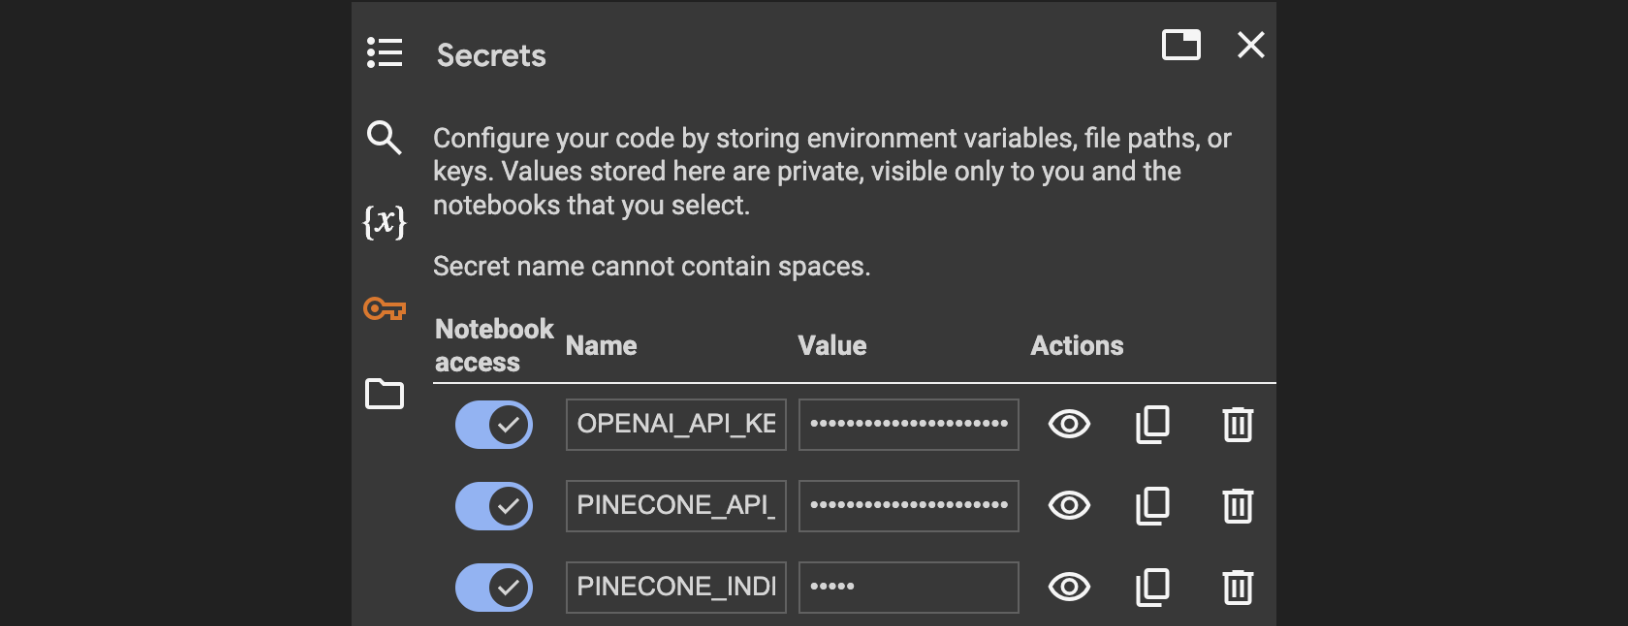

Once you've configured the keys OPENAI_API_KEY and PINECONE_API_KEY, it's time to set up the environment variables. These variables are crucial for the code to access the necessary resources and services, ensuring smooth execution.

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['PINECONE_API_KEY'] = userdata.get('PINECONE_API_KEY')
os.environ['PINECONE_INDEX_NAME'] = userdata.get('PINECONE_INDEX_NAME')

The code aims to read an entire directory and upload all PDF files. We need to connect Google Colab with your Google Drive to facilitate this process. This connection allows us to access and manipulate the files in your Drive. To establish this connection, execute the following code to connect to your Google Drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Now you can access your Google Drive in the tab on the side.

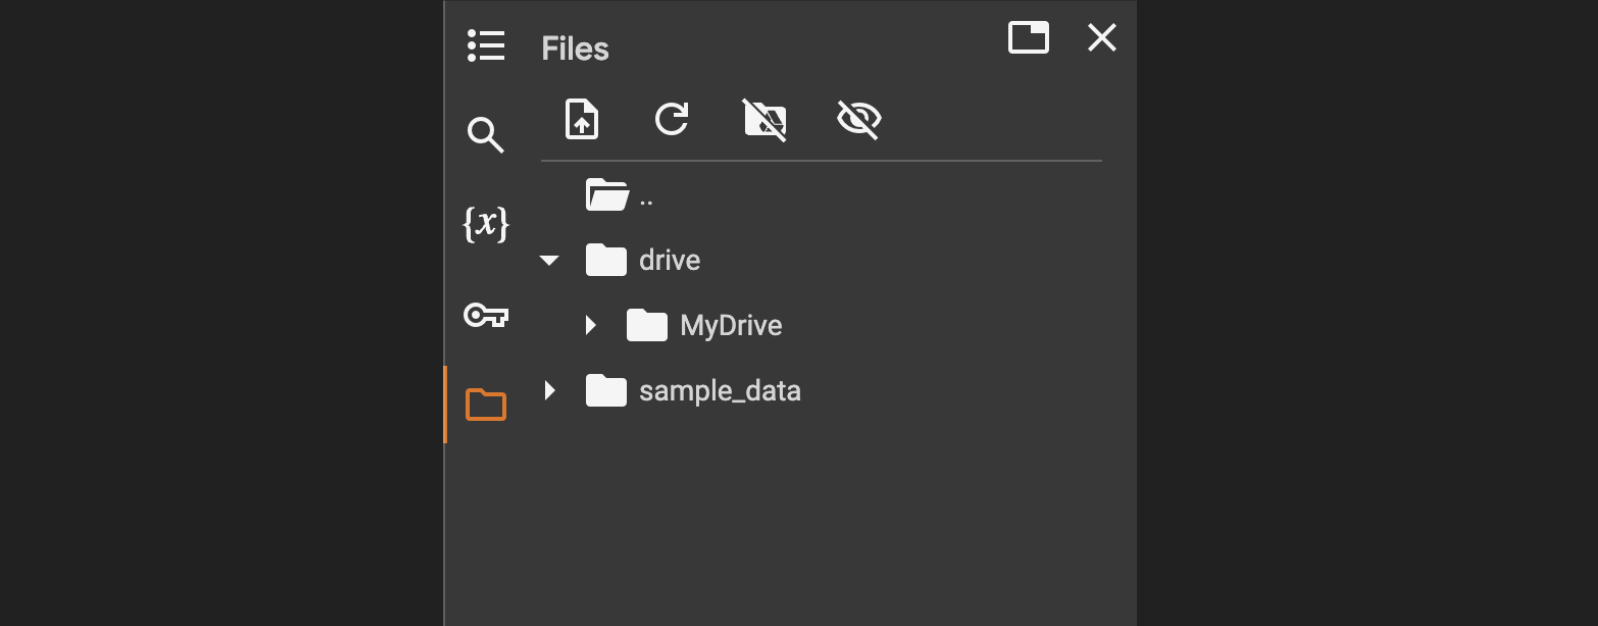

# **Useful methods**

Below, we have a set of methods that will help us read PDF files, insert this information into Pinecone, and read information directly from the vector database.

In [ ]:
# Import necessary libraries
import os
import pinecone
from pinecone import PodSpec
from langchain_community.vectorstores import Pinecone as PineconeVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

def chunk_data(data, chunk_size=256):
    """
    Splits the input data into smaller chunks for efficient processing.
    This is useful for handling large texts by breaking them down into
    manageable sizes, making them easier to process and analyze.

    Parameters:
    - data: The text data to be split.
    - chunk_size: The maximum size of each chunk. Default is 256 characters.

    Returns:
    - A list of text chunks.
    """
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=30)
    chunks = text_splitter.split_documents(data)
    return chunks

def upload_files(directory):
    """
    Uploads PDF files from a specified directory to a Pinecone vector database.
    It automatically creates a new Pinecone index if it doesn't exist, and then
    processes each PDF file by converting its content into text, chunking the text,
    and uploading the chunks along with their embeddings.

    Parameters:
    - directory: The path to the directory containing PDF files to be uploaded.

    Returns:
    - A Pinecone vector store initialized with the uploaded document chunks.
    """
    pc = pinecone.Pinecone()

    # Check if the Pinecone index exists, if not, create a new one
    if userdata.get('PINECONE_INDEX_NAME') not in pc.list_indexes().names():
        pc.create_index(
            name=userdata.get('PINECONE_INDEX_NAME'),
            dimension=1536,
            metric='cosine',
            spec=PodSpec(environment='gcp-starter')
        )

    # Connect to the Pinecone index
    index = pc.Index(userdata.get('PINECONE_INDEX_NAME'))
    embeddings = OpenAIEmbeddings(model='text-embedding-3-small', dimensions=1536)

    # Process each PDF file in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.pdf'):
            file_path = os.path.join(directory, file_name)
            print(f'Loading {file_name}')
            loader = PyPDFLoader(file_path)
            data = loader.load()
            chunks = chunk_data(data, chunk_size=256)

            # Create a vector store for the chunks using Pinecone
            vector_store = PineconeVectorStore.from_existing_index(userdata.get('PINECONE_INDEX_NAME'), embeddings)
            vector_store = PineconeVectorStore.from_documents(chunks, embeddings, index_name=userdata.get('PINECONE_INDEX_NAME'))
            print('Ok')

    return vector_store

def ask_and_get_answer(vector_store, q, k=3):
    """
    Queries the Pinecone vector store with a question and retrieves answers
    based on the similarity of the uploaded documents' content to the question.

    Parameters:
    - vector_store: The Pinecone vector store containing document chunks.
    - q: The question to be asked.
    - k: The number of similar chunks to retrieve for generating the answer. Default is 3.

    Returns:
    - The answer generated by the RetrievalQA chain.
    """

    llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=0.1)
    retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k': k})
    chain = RetrievalQA.from_chain_type(llm=llm, chain_type="stuff", retriever=retriever)
    answer = chain.invoke(q)

    return answer



# **Testing the file upload code**

To perform this test, we will call the "upload_files" method. As a parameter, you must pass the directory path where you want to fetch the PDF files.

The simplest way to discover the correct path is to access the tab on the side and find the desired directory in your Google Drive. Click on the icon with three buttons, and from the drop-down menu, choose the "Copy path" option. Afterward, paste the directory path into the code.


In [ ]:
vector_store = upload_files('/content/drive/MyDrive/AI/Bitcoin')

Now, you can test whether the knowledge from the PDF files you uploaded to Pinecone is being used to process the questions asked. Take your test and create questions that only exist in the PDF files you used.

In [ ]:
question = 'What is bitcoin?'
answer = ask_and_get_answer(vector_store, question)
print(answer)

You can run the code below if you want to delete the Pinecone index.

In [ ]:
#pinecone.Pinecone().delete_index(userdata.get('PINECONE_INDEX_NAME'))